In [83]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import brentq


In [84]:
class quantizer:
    # implements a uniform deadzone quantizer with M levels over the [-A, A] interval
    def __init__(self, M, A=1):
        assert M % 2 == 1, "only considering mid-thread quantizers"
        self.clip = A
        self.offset = (M - 1) // 2
        self.step = 2 * A / M 
        
    def qbin(self, x):
        # return the INDEX of the quantization bin, i.e. an integer in the range [0, M-1]
        if np.max(np.abs(x)) > self.clip:
            raise OverflowError
        return (np.floor(x / self.step + 0.5) + self.offset).astype(int)
    
    def qvalue(self, i):
        # quantization value for bin i
        return self.step * (i - self.offset)
    
    def quantize(self, x):
        # return the quantized value
        return self.qvalue(self.qbin(x))
    
    def qthreshold(self, ix, iy):
        # return the midpoint between quantization bins ix and iy
        assert abs(ix - iy) == 1, "trying to obtain the threshold across more than 2 quantization levels"
        ix = ix + (0.5 if iy > ix else -0.5)
        return (ix - self.offset) * self.step

In [94]:
def test_func(x):
    f0 = 1.2 # Hz
    return 0.9 * np.cos(2 * np.pi * f0 * x)

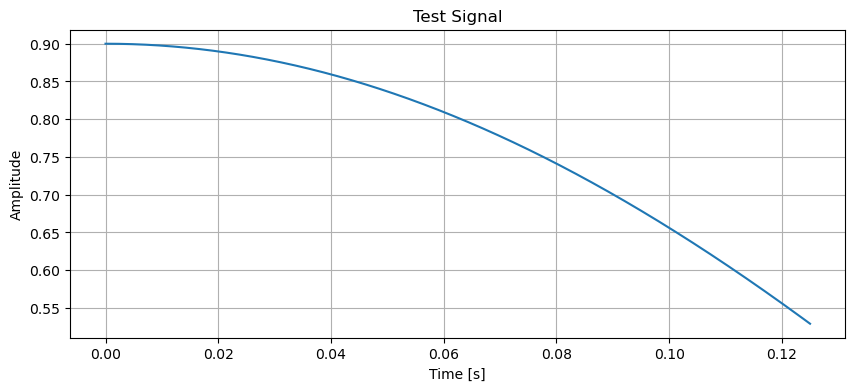

In [96]:
stop_time = 1
x= np.linspace(0, stop_time, 1000) #time vector 

plt.plot(y, test_func(y))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Test Signal')
plt.grid()

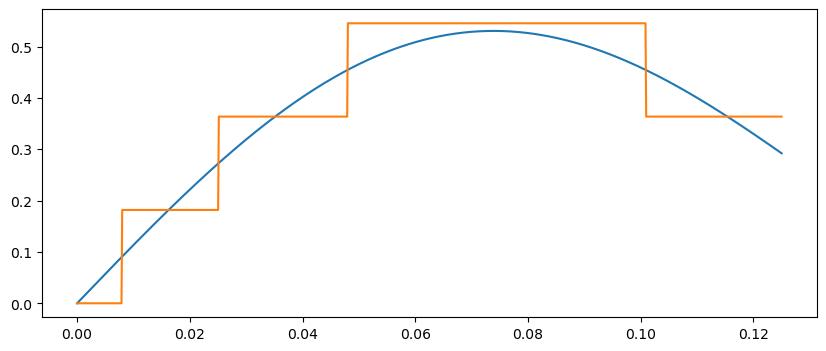

In [88]:
q = quantizer(11)
step = q.step

plt.rcParams["figure.figsize"] = (10,4)
plt.plot(x, test_func(x))
plt.plot(x, q.quantize(test_func(x)));

In [89]:
def amplitude_sampler(f, T, Q, gd=1000):
    # f : input function
    # T : function period
    # Q : quantizer
    # gd : points per period in initial sampling grid
    
    def shifted_f(x, offset):
        # wrapper to shift the input function 
        return f(x) - offset
    
    transitions, bins = [0], [Q.qbin(f(0))]   # transition times and associated quantization bin
    num_samples = T * gd                      # start with a regular sampling to estimate transition points
    
    for n in range(1, num_samples):
        t = n * T / num_samples
        i = Q.qbin(f(t))
        if i != bins[-1]:
            # a level transition has occurred. Find the exact time
            #  first determine the value for the amplitude crossing
            threshold = Q.qthreshold(bins[-1], i)
            #  then determine the exact crossing time between neighboring samples
            transitions.append(brentq(shifted_f, (n - 1) * T / num_samples, t, args=threshold))
            bins.append(i)
    return np.array(transitions), np.array(bins)

Transition instants: [0]
Bins index: [5]


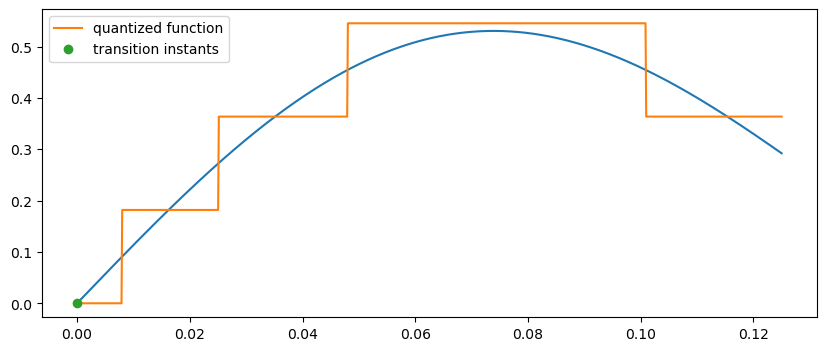

In [93]:
T = int(stop_time)

# transitions and bins
t, q_idx = amplitude_sampler(test_func, T, q)

print('Transition instants: {}'.format(t))
print('Bins index: {}'.format(q_idx))

# bins to quantization values
a = q.qvalue(q_idx)  #--> find the step y value for each bin 

plt.plot(x, test_func(x));
plt.plot(x, q.quantize(test_func(x)), label='quantized function')
plt.plot(t, a, 'o', label='transition instants')
plt.legend()